In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from scipy import interpolate
import math
from scipy.integrate import quad
import Options
from matplotlib import pyplot as plt
import datetime
import time
import tushare
%matplotlib inline
plt.style.use('ggplot')

In [2]:
token = '37f756066bdfd9e6973cc51e088dddd1f3576f970fe77da55592be27'
tushare.set_token(token)
pro = tushare.pro_api(token)

trading_days = pro.query('trade_cal',
                         exchange='SSE',
                         start_date='20150101',
                         end_date='20220101')
num_tds = trading_days.iloc[np.where(trading_days['is_open'])].cal_date.values
trading_days = pd.to_datetime(trading_days.iloc[np.where(
    trading_days['is_open'])].cal_date).astype(str).reset_index(
        drop=True).values
trading_days=trading_days[::-1]

In [3]:
all_info = pd.read_csv("cleaned_data_50ETF_option.csv", low_memory=False)
shibor_info = pd.read_csv("combined_SHIBOR.csv")
index_info = pd.read_csv('data_50ETF_index.csv')
index_info = index_info[index_info.date >= all_info.date[0]].reset_index(
    drop=True)

In [12]:
pd.to_datetime(all_info.date.unique())[0].strftime('%Y-%m-%d')

'2015-02-09'

In [14]:
shibor_dates = np.array([1., 7., 14., 30., 90., 180., 270., 360.])

info_dict = {'date': [], 'exe_date': [], 'implied_vol': []}
trading_dates = pd.to_datetime(all_info.date.unique())
indexes = index_info.close.values


def abs_diff(x):
    s = x.values[0]
    for k in range(1, len(x)):
        s -= x.values[k]
    return np.abs(s)


implied_index = []
all_dict = {day: [] for day in trading_dates}
all_tuples = []
ptm_df = pd.DataFrame({'dtm': [], 'call_imp': [], 'put_imp': []})
for day in tqdm(trading_dates):
    td = day.strftime('%Y-%m-%d')
    td_index = np.where(trading_days == td)[0][0]
    td_shibor = shibor_info[shibor_info.date == td].iloc[0].values[1:]

    shibor_helper = interpolate.interp1d(shibor_dates,
                                         td_shibor,
                                         kind='slinear')

    td_info = all_info[all_info.date == td]

    td_mats = np.sort(td_info.exe_enddate.unique())

    td_shibor = shibor_info[shibor_info.date == td].values[0][1:]

    td_shibor = td_shibor[-1] / 100

    temp_imp = []
    for maturity in td_mats:

        ptmday = (pd.to_datetime(maturity) - day).days + 1

        mat_info = td_info[td_info.exe_enddate == maturity]
        available_prices = mat_info.exe_price.sort_values().unique()
        atm = mat_info.groupby("exe_price").apply(
            lambda x: abs_diff(x['close'])).idxmin()
        call = mat_info[(mat_info.exe_price == atm)
                        & (mat_info.exe_mode == 'call')]
        put = mat_info[(mat_info.exe_price == atm)
                       & (mat_info.exe_mode == 'put')]

        discount = np.exp(-td_shibor * ptmday / 360)
        implied_underlying = call.close.values[0] - put.close.values[
            0] + atm * discount
        temp_imp.append(implied_underlying)
        option = Options.Strategy()
        option.getData(atm, td_shibor, ptmday / 360, 0.2)
        implied_vol = option.EuroCallIV(implied_underlying,
                                        call.close.values[0])
        implied_vol_p = option.EuroPutIV(implied_underlying,
                                         put.close.values[0])

        all_tuples.append(
            (eval(''.join(td.split('-'))), eval(''.join(maturity.split('-'))),
             ptmday, implied_vol, implied_vol_p))
        tmp = pd.DataFrame({
            'dtm': [ptmday],
            'call_imp': [implied_vol],
            'put_imp': [implied_vol_p],
            'date': [td]
        })
        ptm_df = pd.concat([ptm_df, tmp])
    implied_index.append(np.mean(temp_imp))

100%|██████████████████████████████████████████████████████████████████████████████| 1504/1504 [01:13<00:00, 20.35it/s]


In [15]:
ptm_df=ptm_df.reset_index(drop=True)

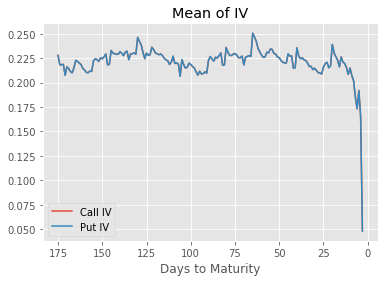

In [16]:
wa = ptm_df.groupby(ptm_df.dtm).mean().reset_index(drop=True)
xa = np.array(range(len(wa), 0, -1))
xa = xa[:-2]
wa = wa[:-2]
plt.plot(xa, wa.call_imp.values[::-1])
plt.plot(xa, wa.put_imp.values[::-1])
plt.gca().invert_xaxis()
plt.xlabel("Days to Maturity")
plt.legend(["Call IV", "Put IV"])
plt.title("Mean of IV")
plt.show()

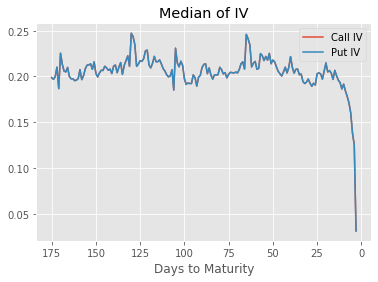

In [17]:
wa = ptm_df.groupby(ptm_df.dtm).median().reset_index(drop=True)
xa = np.array(range(len(wa), 0, -1))
xa = xa[:-2]
wa = wa[:-2]
plt.plot(xa, wa.call_imp.values[::-1])
plt.plot(xa, wa.put_imp.values[::-1])
plt.gca().invert_xaxis()
plt.xlabel("Days to Maturity")
plt.legend(["Call IV", "Put IV"])
plt.title("Median of IV")
plt.show()

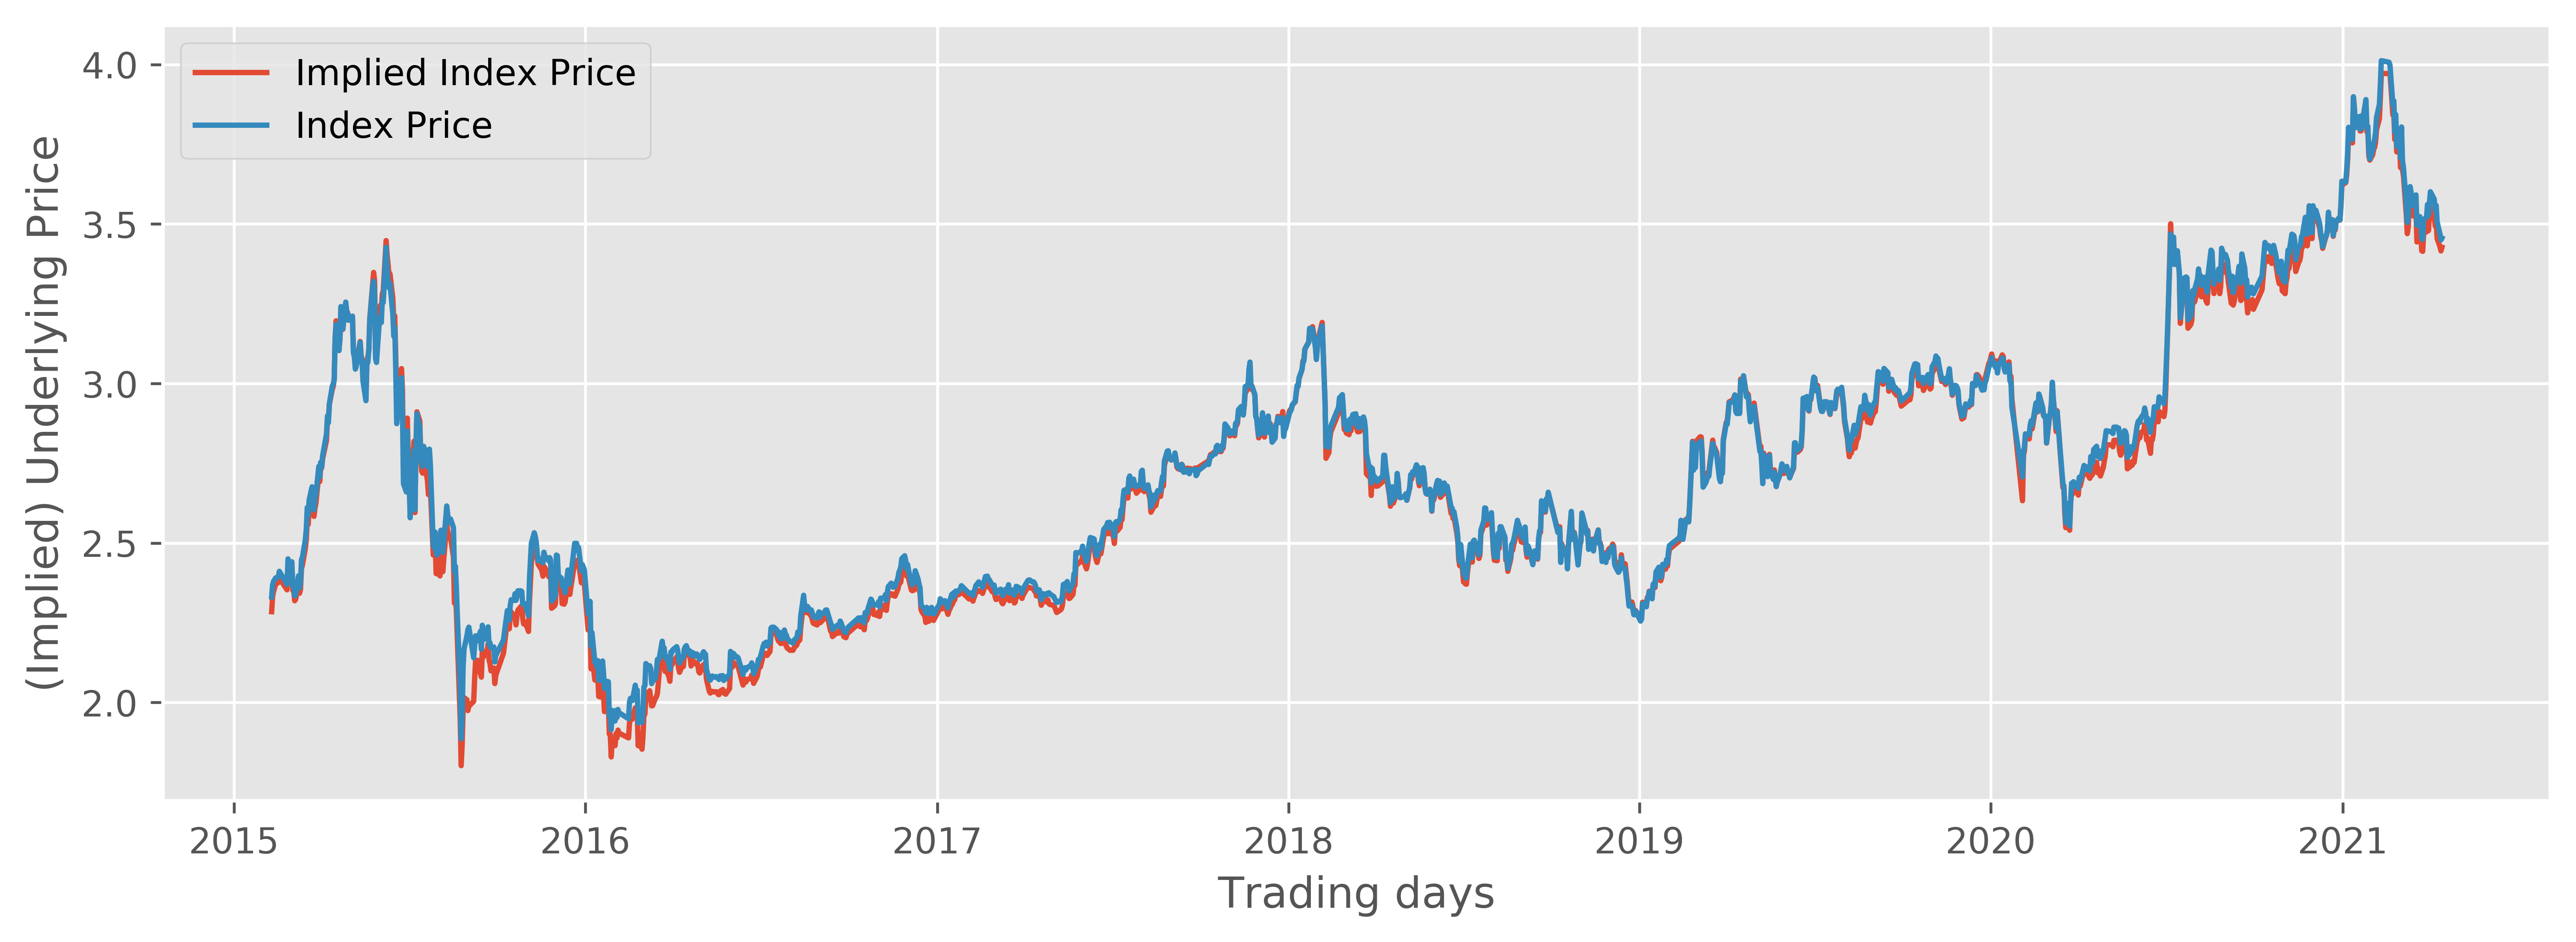

In [18]:
dates = pd.to_datetime(ptm_df.date.sort_values()).unique()

plt.figure(figsize=(12, 4), dpi=600)
plt.style.use('ggplot')

plt.xlabel('Trading days')
plt.ylabel('(Implied) Underlying Price')

plt.plot(dates, implied_index)
plt.plot(dates, indexes)

plt.legend(['Implied Index Price', 'Index Price'])

plt.show()

In [19]:
call_dir = 'cd_vol//call//'
put_dir = 'cd_vol//put//'
lengths = []
maturity = all_info.exe_enddate.apply(
    lambda x: eval(''.join(x.split('-')))).unique()
for k in sorted(maturity):
    selected = np.array([[tup[0], tup[-2], tup[-1], tup[2]]
                         for tup in all_tuples if tup[1] == k])
    dates, imp_vol, ivp, dtm = selected[:, 0].astype(
        int), selected[:, 1], selected[:, 2], selected[:, 3]
    lengths.append(dates.shape[0])
    cfn = call_dir + 'implied_volatility_{}.csv'.format(k)
    pfn = put_dir + 'implied_volatility_{}.csv'.format(k)
    cv = pd.DataFrame({'date': dates, 'imp_vol': imp_vol, 'to_maturity': dtm})
    pv = pd.DataFrame({'date': dates, 'imp_vol': ivp, 'to_maturity': dtm})
    cv['imp_change'] = cv['imp_vol'].pct_change()
    pv['imp_change'] = pv["imp_vol"].pct_change()
    cv['week_day'] = cv.date.apply(lambda x: datetime.datetime.fromtimestamp(
        time.mktime(time.strptime(str(x), "%Y%m%d"))).weekday())
    pv['week_day'] = pv.date.apply(lambda x: datetime.datetime.fromtimestamp(
        time.mktime(time.strptime(str(x), "%Y%m%d"))).weekday())
    cv.to_csv(cfn, index=False)
    pv.to_csv(pfn, index=False)